# Installations / Préparations

## install

In [1]:
!pip install importlib-metadata==4.13.0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Attempting uninstall: importlib-metadata
    Found existing installation: importlib-metadata 6.0.0
    Uninstalling importlib-metadata-6.0.0:
      Successfully uninstalled importlib-metadata-6.0.0


In [2]:
!pip install git+https://github.com/osigaud/bbrl_gym

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/osigaud/bbrl_gym to /tmp/pip-req-build-ig9kd3rx
  Running command git clone --filter=blob:none --quiet https://github.com/osigaud/bbrl_gym /tmp/pip-req-build-ig9kd3rx
  Resolved https://github.com/osigaud/bbrl_gym to commit 5557075ecd7d4171ac0c21be3c69a94bcae655a9
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 45.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 58.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 374.5/374.5 KB 32.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for bbrl-gym: filename=bbrl_gym-1.2.5-py3-none-any.whl size=17599 sha256=ef8f7b325702689202e

## import

In [51]:
import os
from typing import Tuple, List

import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import random

from mazemdp.toolbox import egreedy, egreedy_loc
#from mazemdp.toolbox import softmax, sample_categorical
from mazemdp.maze_plotter import show_videos
from mazemdp.mdp import Mdp
from bbrl_gym.envs.maze_mdp import MazeMDPEnv

# For visualization
os.environ["VIDEO_FPS"] = "5"
if not os.path.isdir("./videos"):
    os.mkdir("./videos")

from IPython.display import Video

import gym
import bbrl_gym

## settings

In [159]:
# Settings
MAZE_LARGEUR = 4
MAZE_HAUTEUR = 3
RATIO = 0.25

NB_EPISODES = 10
TIMEOUT = 50
NB_REPLAY = 5     # nb de replay par épisode
TAILLE_BATCH_MAX = 15     # taille max du mini batch pour un replay
NB_BUTS_MAX = 15   # nb max de buts annexes considéré pour le replay

EPSILON = 0.1
TAU = 0.1
ALPHA = 0.5

## création du maze

In [145]:
env = gym.make("MazeMDP-v0", kwargs={"width": MAZE_LARGEUR, "height": MAZE_HAUTEUR, "ratio": RATIO})
env.reset()

# in dynamic programming, there is no agent moving in the environment
env.init_draw("The maze")

Output()

# Hindsight Experience Replay 3D

## utils

In [6]:
# Renvoie la meilleure policy pour un but donné
def get_policy_from_q(Q: np.ndarray, but: int) -> np.ndarray:
    # Outputs a policy given the action values
    policy = np.argmax(Q[:, but, :], axis=1)
    return policy

In [7]:
# calcul la matrice de trnasition adéquate pour un but donné
def calcul_transition(mdp: MazeMDPEnv, but):
    transition_matrix = np.zeros( (mdp.nb_states, mdp.action_space.n, mdp.nb_states) )

    for s in range(mdp.nb_states-1):
        x = mdp.coord_x[s]
        y = mdp.coord_y[s]

        # NORD #
        # si case tout au nord, pas de changement d'état possible dans cette direction
        if x == 0 :
            transition_matrix[s][0][s] = 1.0
        # SUD #
        # si case tout au sud, pas de changement d'état possible dans cette direction
        if x == MAZE_HAUTEUR-1 :
            transition_matrix[s][1][s] = 1.0
        # EST #
        # si case tout à l'est, pas de changement d'état possible dans cette direction
        if y == MAZE_LARGEUR-1 :
            transition_matrix[s][2][s] = 1.0
        # OUEST
        # si case tout à l'ouest, pas de changement d'état possible dans cette direction
        if y == 0 :
            transition_matrix[s][3][s] = 1.0

        for s_prime in range(mdp.nb_states-1):
            # Regarde les relations entre s et les autres états
            if (s != s_prime):
                x_prime = mdp.coord_x[s_prime]
                y_prime = mdp.coord_y[s_prime]
                # NORD #
                if (x_prime == x-1) and (y_prime == y):
                    transition_matrix[s][0][s_prime] = 1.0
                # SUD #
                if (x_prime == x+1) and (y_prime == y):
                    transition_matrix[s][1][s_prime] = 1.0
                # EST #
                if (x_prime == x) and (y_prime == y+1):
                    transition_matrix[s][2][s_prime] = 1.0
                # OUEST #
                if (x_prime == x) and (y_prime == y-1):
                    transition_matrix[s][3][s_prime] = 1.0

        # Si une action n'a aucune transition, alors on boucle sur le même état
        for a in range(mdp.action_space.n):
            if all(transition_matrix[s,a] == 0):
                transition_matrix[s,a,s] = 1.0

    # Transition Matrix of terminal states
    transition_matrix[but, :, :] = 0
    transition_matrix[but, :, -1] = 1

    return transition_matrix

In [8]:
# calcul et stocke les matrices de récompense et de transition pour un but donné
def calcul_goal(mdp: MazeMDPEnv, but: int):
    # calcul du nouveau point d'origine des récompenses
    new_r = np.zeros((mdp.nb_states, mdp.action_space.n))
    new_r[but] = np.ones(mdp.action_space.n)
    new_r[but] = np.ones(mdp.action_space.n)

    # calcul de la nouvelle matrice de transition
    new_P = calcul_transition(mdp, but)

    return new_r, new_P

In [10]:
# modifie la MDP en fonction du goal
def maj_goal(mdp: MazeMDPEnv, but, r_list, P_list):
    # modification de l'état but
    mdp.mdp.r = r_list[but]
    mdp.P = P_list[but]
    mdp.mdp.P = P_list[but]
    mdp.mdp.plotter.terminal_states = [but]

## HER methods

In [130]:
# 

def her_discret(
    mdp: MazeMDPEnv,
    Q: np.ndarray,
    rb: list,
    alpha: float,
    render):

    # tirage du mini batch parmi les transitions du Replay Buffer
    # nb d'utilisation aléatoire ? PAS POUR L'INSTANT : valeur trop élevée dans la Q-Table
    # (possibilité de répétition des transitions)
    taille_batch = min(TAILLE_BATCH_MAX, len(rb))
    rb_batch = random.sample(rb, taille_batch)

    # pour chaque transiton du mini batch
    for  i in range(taille_batch):
        # récupération des données de la transition
        s, a, r, s_prime, but = rb_batch[i]

        if render:
            # Show the agent in the maze
            mdp.mdp.plotter.terminal_states = [but]    # modifie le plotter
            mdp.draw_v_pi(Q[:,but,:], get_policy_from_q(Q, but))

        # calcul des nouvelles valeurs de Q
        delta = r + mdp.gamma * np.max(Q[s_prime, but]) - Q[s, but, a]
        Q[s, but, a] += alpha * delta

        if render:
            # Show the agent in the maze
            mdp.draw_v_pi(Q[:,but,:], get_policy_from_q(Q, but))

    return Q

## Epsilon-greedy

In [160]:
# --------------------------- Q-Learning epsilon-greedy version -------------------------------#

# Given an exploration rate epsilon, the QLearning algorithm computes the state action-value function
# based on an epsilon-greedy policy
# alpha is the learning rate


def her_ql_3d_eps(
    mdp: MazeMDPEnv,
    epsilon: float,
    nb_episodes: int = 20,
    timeout: int = 50,
    alpha: float = 0.5,
    render: bool = True,
) -> Tuple[np.ndarray, List[int]]:
    # Initialize the state-goal-action value function
    # 3D : états / buts / actions
    Q = np.zeros((mdp.nb_states, mdp.nb_states, mdp.action_space.n))
    r_list = []   # récompenses selon les buts (but, état, action, récompense)
    P_list = []   # transition selon les buts (but, état, action, état)
    t_list = []   # nb d'étapes par épisode

    # calcul initial des matrices pour chacun des buts
    for s in range(mdp.nb_states-1):
        new_r, new_P = calcul_goal(mdp, s)
        r_list.append(new_r)
        P_list.append(new_P)
  
    # Run learning cycle
    mdp.mdp.timeout = timeout  # episode length

    if render:
        mdp.init_draw("Q-learning HER")

    for _ in tqdm(range(nb_episodes)):
        # Draw the first state of episode i using a uniform distribution over all the states
        s = mdp.reset(uniform=True)

        # tirage de l'état but de l'épisode (hors état puit)
        but = np.random.randint(mdp.nb_states-1)

        maj_goal(mdp, but, r_list, P_list)    # modification des matrices correspondante au but principal

        rb = []     # initialisation du replay buffer de cet épisode

        ## en attendant de compléter l'accès aux valeurs du Replay Buffer ##
        sb = []     # initialisation du buffer des états parcourrus
        ab = []     # initialisation du buffer des actions effectuées
        ##                           ##########                           ##

        done = mdp.mdp.done()

        # boucle de l'épisode déroulée de manière normale
        while not done:
            if render:
                # Show the agent in the maze
                mdp.draw_v_pi(Q[:,but,:], get_policy_from_q(Q, but))

            # ajout de l'état actuel au Buffer du chemin
            sb.append(s)

            # Draw an action using an epsilon-greedy policy
            a = egreedy(Q[:, but, :], s, epsilon)

            # ajout de l'action effectuée au Buffer des actions
            ab.append(a)

            # Perform a step of the MDP
            [s_prime, r, done, _] = mdp.step(a)

            # Replay Buffer pour enregistrer les transitions : tuple (s, a, r , s', but)
            rb.append( (s, a, r, s_prime, but) )

            # Update the agent position
            s = s_prime

        # boucle de l'expérience replay sur chaque step
        for t in range(mdp.mdp.timestep -1):
            # choix des buts annexes parmi le chemin parcouru
            # nombre de but aléatoire ? NON : bcp trop de valeur dans le Replay Buffer pour un seul épisode
            # (pas deux fois le même état but ?)
            nb_buts = min(NB_BUTS_MAX, len(sb))
            goal = random.sample(sb, nb_buts)

            # récupération des états et de l'action de la transition au temps t
            s = sb[t]
            s_prime = sb[t+1]
            a = ab[t]

            # pour chaque but annexe, ou ajoute la transition au Replay Buffer
            for g in range(len(goal)):
                but = goal[g]     # récupération du but
                r = r_list[but][s][a]     # récupération de la récompense
                rb.append( (s, a, r, s_prime, but) )      # ajout au Buffer

        # boucle du calcul des nouvelles valeurs de Q par HER
        for n in range(NB_REPLAY):
            # modification de Q par HER sur un mini batch
            Q = her_discret(mdp, Q, rb, alpha, render)

        # compteur du nombre d'étape d'un épisode
        t_list.append(mdp.mdp.timestep)

    return Q, t_list

In [165]:
Q, _ = her_ql_3d_eps(env, EPSILON, NB_EPISODES, TIMEOUT)

Output()

  0%|          | 0/10 [00:00<?, ?it/s]

## Visualisation

In [166]:
show_videos("videos/", "Q-learningHER")

Converting videos/Q-learningHER.avi


In [171]:
# visualisation
but = 4
print("état but : ", but)
env.mdp.plotter.terminal_states = [but]
env.draw_v_pi(Q[:,but,:], get_policy_from_q(Q, but), title="Q-learning e-greedy"+str(but))

état but :  4


Output()

## Courbes d'apprentissages

In [175]:
def plot_her_3d_goal(env, epsilon, tau, nb_episodes, timeout, alpha, render):
    q, t_list1 = her_ql_3d_eps(env, epsilon, nb_episodes, timeout, alpha, render)

    plt.figure(figsize=(18,5))
    plt.plot(range(nb_episodes), t_list1, label='q-learning epsilon')
    plt.xlabel('Number of episodes')
    plt.ylabel('Number of steps to reach the goal')
    plt.legend(loc='upper right')
    plt.title("Comparison of Time to reach the goal")
    plt.show()

  0%|          | 0/500 [00:00<?, ?it/s]

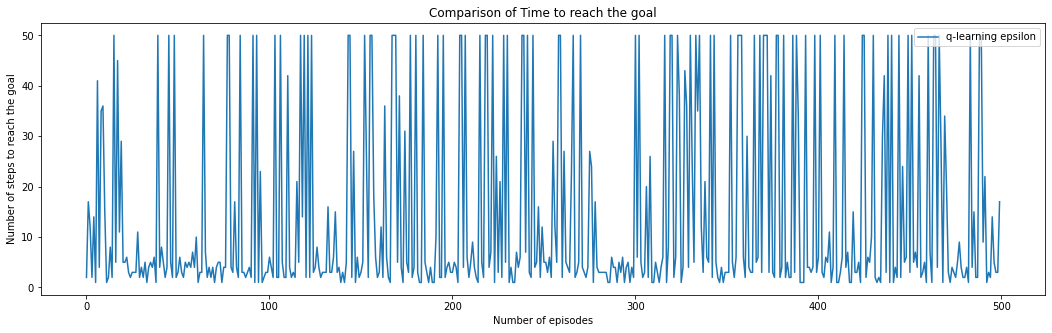

In [177]:
plot_her_3d_goal(env, EPSILON, TAU, 500, TIMEOUT, ALPHA, False)

# moins bon que QL en 3D ?
# probablement en fonction du nombre de replay, des tailles des batchs, etc